In [3]:
from typing import TypedDict, List, Dict
from langgraph.graph import StateGraph, START, END
import random

In [4]:
class AgentState(TypedDict):
    name: str
    number: List[int]
    counter: int

def greeting_node(state: AgentState) -> AgentState:
    """Greeting Node"""
    state['name'] = f"Hi there, {state['name']}!"
    state['counter'] = 0
    return state

def random_node(state: AgentState) -> AgentState:
    """Random Node"""
    state['number'].append(random.randint(0, 10))
    state['counter'] += 1

    return state

def should_continue(state: AgentState) -> AgentState:
    """Should Continue"""
    if state['counter'] < 5:
        print("Entering loop", state['counter'])
        return "loop"
    else:
        return "exit"


In [6]:
graph = StateGraph(AgentState)

graph.add_node('greeting_node', greeting_node)
graph.add_node('random_node', random_node)

graph.add_edge(START, "greeting_node")
graph.add_edge("greeting_node", "random_node")

graph.add_conditional_edges("random_node", should_continue, {
    "loop": "random_node",
    "exit": END})

app = graph.compile()

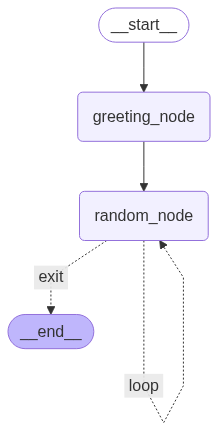

In [7]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
answer = app.invoke({"name": "z", "number": [1, 2, 3], "counter": 0})

Entering loop 1
Entering loop 2
Entering loop 3
Entering loop 4


In [11]:
print(answer)

{'name': 'Hi there, z!', 'number': [1, 2, 3, 9, 8, 8, 10, 7], 'counter': 5}


## Exercise V

In [82]:
from typing import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    player_name: str
    guesses: List[int]
    attempts: int
    lower_bound: int
    upper_bound: int
    target_number: int
    last_higher: int
    last_lower: int
    hint: str

def setup(state: AgentState) -> AgentState:
    """Set up the boundary"""
    state['lower_bound'] = 1
    state['upper_bound'] = 20
    return state

def guess(state: AgentState) -> AgentState:
    if "hint" not in state:
        guess = random.randint(state['lower_bound'], state['upper_bound'])
    elif state['hint'] == "lower":
        state['last_higher'] = state['guesses'][-1] - 1
        lower = state['last_lower'] or state['lower_bound']
        guess = random.randint(lower, state['last_higher'])
    elif state['hint'] == "higher":
        state['last_lower'] = state['guesses'][-1] - 1
        upper = state['last_higher'] or state['upper_bound']
        guess = random.randint(state['last_lower'], upper)

    state['guesses'].append(guess)
    state['attempts'] += 1
    return state

def hint(state: AgentState) -> AgentState:
    if state['guesses'][-1] > state['target_number']:
        print(f"{state['player_name']}, lower the attempts!")
        state['hint'] = "lower"
    elif state['guesses'][-1] < state['target_number']:
        print(f"{state['player_name']}, higher the attempts!")
        state['hint'] = "higher"
    else:
        state['hint'] = "success"
        print(f"{state['player_name']}, You got it!")
    return state

def decide_continue(state: AgentState) -> AgentState:
    if state['attempts'] == 7 or state['guesses'][-1] == state['target_number']:
        return "exit"
    else:
        return "continue"

In [83]:
graph = StateGraph(AgentState)

graph.add_node('setup_node', setup)
graph.add_node('guess_node', guess)
graph.add_node('hint_node', hint)

graph.add_edge(START, "setup_node")
graph.add_edge("setup_node", "guess_node")
graph.add_edge("guess_node", "hint_node")

graph.add_conditional_edges("hint_node", decide_continue, {
    "exit": END,
    "continue": "guess_node",
})

app = graph.compile()

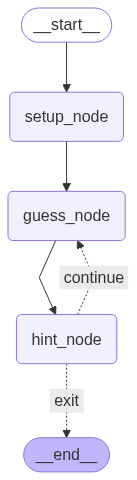

In [75]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [84]:
answer = app.invoke({"player_name": "z", "guesses": [], "attempts": 0, "lower_bounder":1, "upper_bound": 20, "target_number": 13})

print(answer)

z, lower the attempts!


KeyError: 'last_lower'